<a id='persistence'></a> 
# 2. Build a univariate time series baseline

In [ ]:
import pandas as pd
import numpy as np
import pprint
import time
import pytz
from pandas import datetime
from datetime import datetime, timedelta

import itertools

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams  # Dynamic rc settings
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## The persistence algorithm uses the value at the current time step (t) to predict the expected outcome at the next time step (t+1). 

###  Step 1. Transform the univariate dataset into a supervised learning problem. 
Time series prediction as supervised learning. Drawing heavily from <a href="https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/ " target="_blank">this blog</a> .

### Step 2. Establish the train and test datasets for the test harness.
### Step 3. Define the persistence model.
### Step 4. Make a forecast and establish a baseline performance.



In [34]:
n_test = int(365*24*1)
## comparison only on the test dataset n_test
# city: Tallahassee
mae_tal_bs = np.abs(tal.demand[-n_test:] - tal.forecast[-n_test:]).mean()
rmse = np.sqrt(((tal.demand[-n_test:] - tal.forecast[-n_test:])**2).mean())
print('mae: %.4f MWh' % mae_tal_bs)
print('rmse: %.4f MWh' % rmse)

mae: 11.9977 MWh
rmse: 17.6267 MWh


### Forecast provided by the government.
### mae: 11.9881MWh
### rmse:17.616 MWh

<a id='onestep'></a> 
## 2.1  Naive Forecast baseline model for One step TS prediction

In [43]:
# create lagged dataset
lag1 = tal_uni.shift(1)
dataframe = pd.concat([lag1, tal_uni], axis=1) 
dataframe.columns = ['t-1', 't']
# drop the records of NaN
dataframe.dropna(inplace=True)

In [40]:
dataframe.head()

,t-1,t
2015-07-01 01:00:00,NaN,225.0
2015-07-01 02:00:00,225.0,222.0
2015-07-01 03:00:00,222.0,213.0
2015-07-01 04:00:00,213.0,206.0
2015-07-01 05:00:00,206.0,207.0


In [44]:
# split into train and test sets
X = dataframe.values
n_test = int(365*24*1) 
train_bl1, test_bl1 = X[:-n_test], X[-n_test:] 
# split into input and output
X_train_bl1, y_train_bl1 = train_bl1[:,0], train_bl1[:,1] 
X_test_bl1, y_test_bl1 = test_bl1[:,0], test_bl1[:,1]

In [38]:
# Naive forecast model
def model_persistence(x): 
    return x

In [39]:
# walk-forward validation
predictions = list() 
for x in X_test_bl1:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(y_test_bl1, predictions)) 
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.962


## Using the Naive forecast we have already achieved good RMSE. 

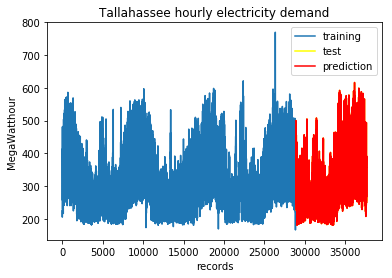

In [40]:
# plot the training set 
plt.plot(train_bl1[:,0])
# set the start and the end of test set
off_s = len(train_bl1)
off_e = off_s + len(predictions) 
# plot the test set
plt.plot(list(range(off_s,off_e)),test_bl1[:,-1], color = 'yellow')
# plot the forecasts in red
plt.plot(list(range(off_s,off_e)), predictions, color='red')
plt.xlabel('records')
plt.ylabel('MegaWatthour')
plt.legend(['training','test','prediction'])
plt.title('Tallahassee hourly electricity demand')
plt.show()

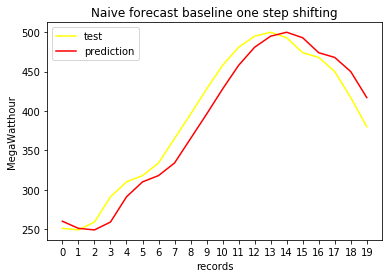

In [41]:
### Since the hourly data are a lot and we could not see clearly how well is the prediction regarding the test in the graph. We zoom in to the first 20 predictions. We will see the prediction just one shift related to the test as we expected. 

# Zoom to see the predicted to the expected demand on the test dataset
plt.xticks(np.arange(0,20, step=1))
plt.plot(test_bl1[:,-1][:20],color ='yellow')
plt.plot(predictions[:20],color='red')
plt.legend(['test','prediction'])
plt.xlabel('records')
plt.ylabel('MegaWatthour')
plt.title('Naive forecast baseline one step shifting')
plt.show()

## 2.1.1 Residual errors exploration
## Forecast errors on time series regression problems are called residuals or residual errors. Careful exploration of residual errors on the time series prediction problem can tell us a lot about our forecast model and even suggest improvements. 

#### Generally, when exploring residual errors we are looking for patterns or structure. A sign of a pattern suggests that the errors are not random.

#### We expect the residual errors to be random, because it means that the model has captured all of the structure and the only error left is the random fluctuations in the time series that cannot be modeled. A sign of a pattern or structure suggests that there is more information that a model could capture and use to make better predictions.

In [1]:
def oneDArray(x):
    return list(itertools.chain(*x))
# equal ## flat = [x for sublist in nested for x in sublist]

In [42]:
def residuals_analysis(residuals):
    # figure for subplots
    fig, axs = plt.subplots(2, 2,figsize=(20,15))
    fig.text(0.5,0.93,'Residual analysis',horizontalalignment='center',
       verticalalignment='top',fontsize="xx-large")
    # scatter plot of residual errors
    axs[0, 0].scatter(residuals.index, residuals)
    axs[0, 0].set_title('Scatter plot')
    
    # histogram of residual errors
    residuals.hist(ax = axs[0,1])
    axs[0, 1].set_title('Histogram plot')
    
    # density plot of residual errors
    residuals.plot(ax = axs[1, 0],kind='kde')
    axs[1, 0].set_title('Density plot')
    
    # qq-plot to check the normality
    axs[1, 1].set_title('Q-Q plot')
    qqplot(np.array(oneDArray(residuals.values)), line='r',ax = axs[1, 1]) 
    
    plt.show()

      0
0  -9.0
1  -2.0
2  10.0
3  32.0
4  19.0


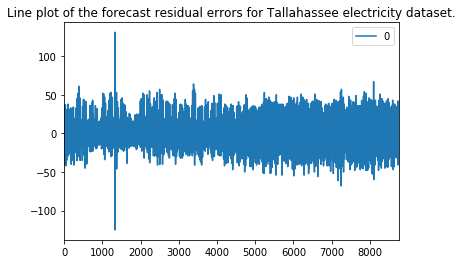

In [44]:
# calculate residuals
residuals_one = [test_bl1[:,1][i]-predictions[i] for i in range(len(predictions))] 
residuals_one = pd.DataFrame(residuals_one)
print(residuals_one.head())
# plot residuals

residuals_one.plot()
plt.title('Line plot of the forecast residual errors for Tallahassee electricity dataset.')
plt.show()

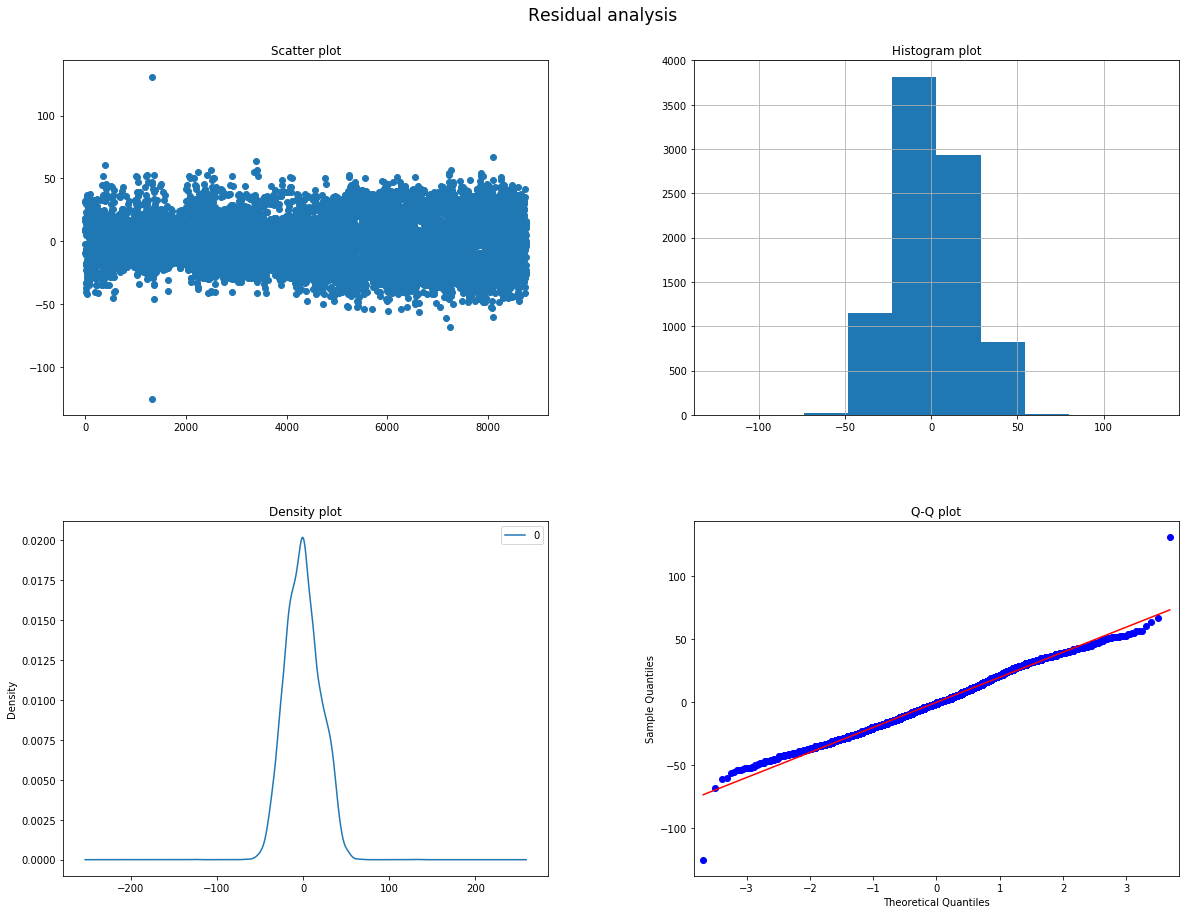

In [45]:
residuals_analysis(residuals_one)

### It seems to be random.

In [46]:
# summary statistics
print(residuals_one.describe())

                 0
count  8760.000000
mean     -0.000342
std      19.962978
min    -125.000000
25%     -14.000000
50%      -1.000000
75%      13.000000
max     131.000000


### The mean value of the residual errors close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made.The mean is close to zero. 

### Plots can be better to help understand the distribution of errors than the descriptive statistics. We would expect the forecast errors to be normally distributed around a zero mean. 

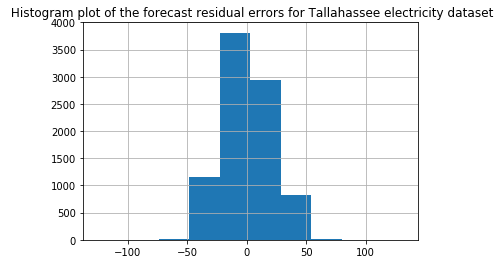

In [47]:
# histogram plot
residuals_one.hist()
plt.title(' Histogram plot of the forecast residual errors for Tallahassee electricity dataset')
plt.show()

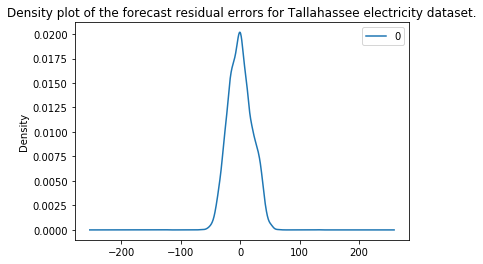

In [48]:
# density plot
residuals_one.plot(kind='kde')
plt.title('Density plot of the forecast residual errors for Tallahassee electricity dataset.')
plt.show()

### We can see that the distribution does have a Gaussian look, is perhaps more pointy, showing an exponential distribution with some asymmetry.
#### If the plot showed a distribution that was distinctly non-Gaussian, it would suggest that assumptions made by the modeling process were perhaps incorrect and that a different modeling method may be required. A large skew may suggest the opportunity for performing a transform to the data prior to modeling, such as taking the log or square root.

## The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.

In [49]:
# qqplot() input data should be 1D array like. 
res_qq = np.array(oneDArray(residuals_one.values))

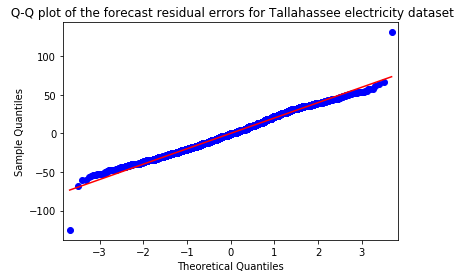

In [50]:
qqplot(res_qq, line='r')   
plt.title(' Q-Q plot of the forecast residual errors for Tallahassee electricity dataset')
plt.show()

In [51]:
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
from scipy import stats
stats.shapiro(res_qq)   # returns(w: The test statistic., p-values)  

(0.9937353134155273, 3.642139309592688e-19)

In [52]:
#Perform the Kolmogorov-Smirnov test for goodness of fit.
#This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x).
# Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. The KS test is only valid for continuous distributions.
stats.kstest(res_qq, 'norm')

KstestResult(statistic=0.46337612936563016, pvalue=0.0)

## The p-values show that we can reject the null hypothesis and the distribution is not normal distribution. 

### Autocorrelation calculates the strength of the relationship between an observation and observations at prior time steps. We can calculate the autocorrelation of the residual error time series and plot the results. This is called an autocorrelation plot. We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot).


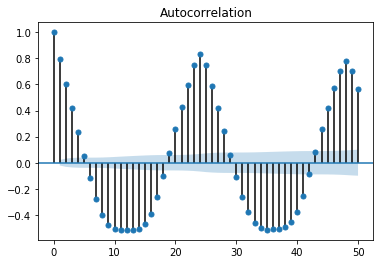

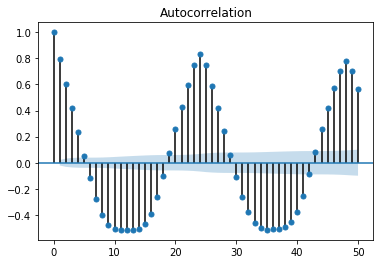

In [53]:
plot_acf(residuals_one, lags = 50)

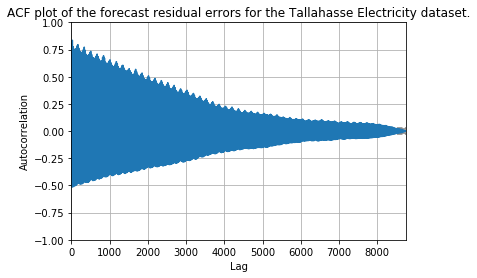

In [54]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(residuals_one)
plt.title('ACF plot of the forecast residual errors for the Tallahasse Electricity dataset.')
plt.show()

### We see a significant autocorrelation in the residual plot. It suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression.

<a id='multisteps'></a>  
## 2.2 Persistence model for multi-steps forecast 24 hours

In [55]:
# Step 1 :Transform the univariate dataset into a supervised learning problem
# convert time series into supervised learning problem
def series_to_supervised(data,  col_names, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
     data: Sequence of observations as a list or NumPy array.
     n_in: Number of lag observations as input (X).
     n_out: Number of observations as output (y).
     dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
     Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]   # n_vars: number of variables(feautures), equal to n_features
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))        # shift one step forward
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [56]:
# Step 2 :  Establish the train and test datasets for the test harness.

def traintest_split(dataframe, n_lag , n_seq , n_test):
    # frame as supervised learning with output of 24 hours prediction.
    series = dataframe.values
    reframed = series_to_supervised(series,dataframe.columns,n_lag, n_seq)
    
    # for multistep forecast drop columns we don't want to predict
         
    list_drop = []
     # drop columns we don't want to predict
    for i in range(1,(n_seq +1)):
        list1 = list(range(1+dataframe.shape[1]*(i+n_lag-1),(dataframe.shape[1]*(i+ n_lag))))
        list_drop.append(list1)
        # convert 2D matrix to 1D array
    list_drop = oneDArray(list_drop)
    reframed.drop(reframed.columns[list_drop], axis=1, inplace=True) 
      
    # split into train and test datasets
    values = reframed.values
    train, test = values[:-n_test], values[-n_test:]
    print('reframed data (%d,%d)'%(reframed.shape[0],reframed.shape[1]))
    print('the training size %d' %len(train))
    print('the test size %d' %len(test))
   
    return train, test

In [57]:
def persistence_multi(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

In [58]:
# Step 4. Make a forecast and establish a baseline performance.
# evaluate the persistence model
def make_forecasts(train, test, n_feature, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X_test, y_test = test[i, 0:n_feature*n_lag], test[i, n_feature*n_lag:]
        # make forecast
        ####### Pls. double check if it is necessary to mean the past values like t-3, t-2, t-1... What is the meaning of the lag????
        forecast = persistence_multi(X_test[n_feature*(n_lag-1)], n_seq)  # X[0] X[n_feature*(n_lag-1)].... last observation ??? when n_lag= 2, how to predict using history..
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [71]:
# Step 4. Make a forecast and establish a baseline performance.
# evaluate the RMSE for each forecast time step
def evaluate_forecasts_nf(test, forecasts, n_feature,n_lag, n_seq):
    rmse_nf_m = []
    mae_nf_m = []
    for i in range(n_seq):
        actual = test[:,(n_feature*n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        print('t+%d RMSE: %f , t+%d MAE: %f' % ((i+1), rmse, (i+1), mae))
        rmse_nf_m.append(rmse)
    return rmse_nf_m, mae_nf_m

A lagged version of the dataset is created where the prior time step (t) is used as the input variable and the next time step (t+1) is taken as the output variable.

In [60]:
n_feature = 1
n_lag = 1
n_seq = 24
n_test = 365*24*1   # the last year as test set
train_multi, test_multi = traintest_split(tal_uni ,n_lag, n_seq, n_test)

reframed data (37611,25)
the training size 28851
the test size 8760


In [61]:
train_multi[0]

array([225., 222., 213., 206., 207., 219., 245., 266., 292., 323., 344.,
       376., 408., 436., 458., 474., 481., 480., 467., 444., 425., 413.,
       378., 340., 307.])

In [62]:
test_multi 

array([[220., 220., 230., ..., 274., 260., 251.],
       [220., 230., 255., ..., 260., 251., 249.],
       [230., 255., 276., ..., 251., 249., 259.],
       ...,
       [288., 269., 257., ..., 337., 314., 288.],
       [269., 257., 250., ..., 314., 288., 269.],
       [257., 250., 249., ..., 288., 269., 257.]])

In [63]:
yhat = make_forecasts(train_multi, test_multi, n_feature, n_lag, n_seq) 

In [64]:
yhat

[[220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0],
 [220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0,
  220.0],
 [230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0,
  230.0],
 [255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0,
  255.0],
 [276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.0,
  276.

In [72]:
rmse_nf_m, mae_nf_m = evaluate_forecasts_nf(test_multi, yhat,n_feature, n_lag, n_seq)

t+1 RMSE: 19.974459 , t+1 MAE: 16.127169
t+2 RMSE: 37.872197 , t+2 MAE: 31.002854
t+3 RMSE: 54.356643 , t+3 MAE: 44.843721
t+4 RMSE: 69.371993 , t+4 MAE: 57.461073
t+5 RMSE: 82.829239 , t+5 MAE: 68.494064
t+6 RMSE: 94.618211 , t+6 MAE: 77.976484
t+7 RMSE: 104.632313 , t+7 MAE: 85.658790
t+8 RMSE: 112.780641 , t+8 MAE: 91.695776
t+9 RMSE: 119.036471 , t+9 MAE: 96.135160
t+10 RMSE: 123.431018 , t+10 MAE: 99.182078
t+11 RMSE: 126.067565 , t+11 MAE: 101.036986
t+12 RMSE: 127.034001 , t+12 MAE: 101.705594
t+13 RMSE: 126.367571 , t+13 MAE: 101.298630
t+14 RMSE: 124.043708 , t+14 MAE: 99.581393
t+15 RMSE: 120.001193 , t+15 MAE: 96.671575
t+16 RMSE: 114.177654 , t+16 MAE: 92.364155
t+17 RMSE: 106.587751 , t+17 MAE: 86.656963
t+18 RMSE: 97.337395 , t+18 MAE: 79.444635
t+19 RMSE: 86.634758 , t+19 MAE: 70.844521
t+20 RMSE: 74.802068 , t+20 MAE: 60.960845
t+21 RMSE: 62.372834 , t+21 MAE: 50.188242
t+22 RMSE: 50.307013 , t+22 MAE: 39.466324
t+23 RMSE: 40.586685 , t+23 MAE: 30.403881
t+24 RMSE: 36.9

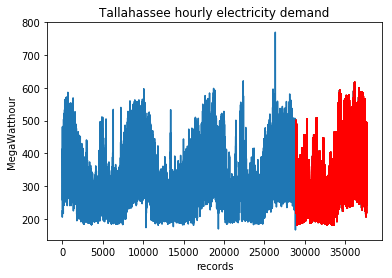

In [66]:
# plot the training set 
plt.plot(train_multi[:,0])
# set the start and the end of test set
off_s_multi = len(train_multi)
off_e_multi = off_s + len(test_multi) 
# plot the test set
plt.plot(list(range(off_s,off_e)),test_multi[:,-24:])
# plot the forecasts in red
plt.plot(list(range(off_s,off_e)), yhat, color='red')
plt.xlabel('records')
plt.ylabel('MegaWatthour')
plt.title('Tallahassee hourly electricity demand')
plt.show()

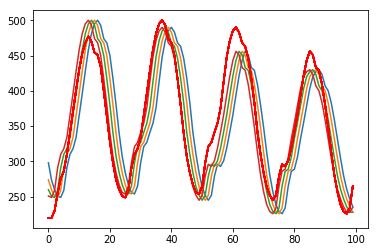

In [67]:
# Zoom to see the predicted to the expected demand on the test dataset
#plt.xticks(np.arange(0,100, step=1))
plt.plot(test_multi[:,-4:][:100])   # -24
plt.plot(yhat[:100],color='red')
plt.show()

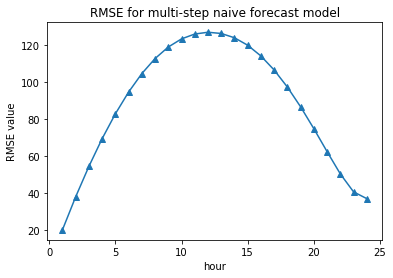

In [73]:
 # evaluate predictions days for each day
#score, scores = evaluate_forecasts_m(test_ml_m[:, :, 0], predictions)
hours = list(range(1,25)) 
plt.plot(hours, rmse_nf_m,  marker='^', label= 'Baseline')
plt.title("RMSE for multi-step naive forecast model")
plt.xlabel("hour")
plt.ylabel("RMSE value")
# show plot
#plt.legend()
plt.show()